##Task A: Baseline Pipeline

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 339kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.94MB/s]


Starting training on cpu...
Epoch 01 | Train Loss: 0.3244 Acc: 90.19% | Val Loss: 0.0900 Acc: 97.28%
Epoch 02 | Train Loss: 0.0691 Acc: 97.87% | Val Loss: 0.0648 Acc: 98.08%
Epoch 03 | Train Loss: 0.0494 Acc: 98.48% | Val Loss: 0.0523 Acc: 98.38%
Epoch 04 | Train Loss: 0.0386 Acc: 98.82% | Val Loss: 0.0502 Acc: 98.50%
Epoch 05 | Train Loss: 0.0313 Acc: 99.01% | Val Loss: 0.0473 Acc: 98.66%
Epoch 06 | Train Loss: 0.0255 Acc: 99.19% | Val Loss: 0.0444 Acc: 98.70%
Epoch 07 | Train Loss: 0.0211 Acc: 99.33% | Val Loss: 0.0386 Acc: 98.90%
Epoch 08 | Train Loss: 0.0184 Acc: 99.40% | Val Loss: 0.0384 Acc: 99.04%
Epoch 09 | Train Loss: 0.0150 Acc: 99.52% | Val Loss: 0.0356 Acc: 98.98%
Epoch 10 | Train Loss: 0.0132 Acc: 99.59% | Val Loss: 0.0321 Acc: 99.00%


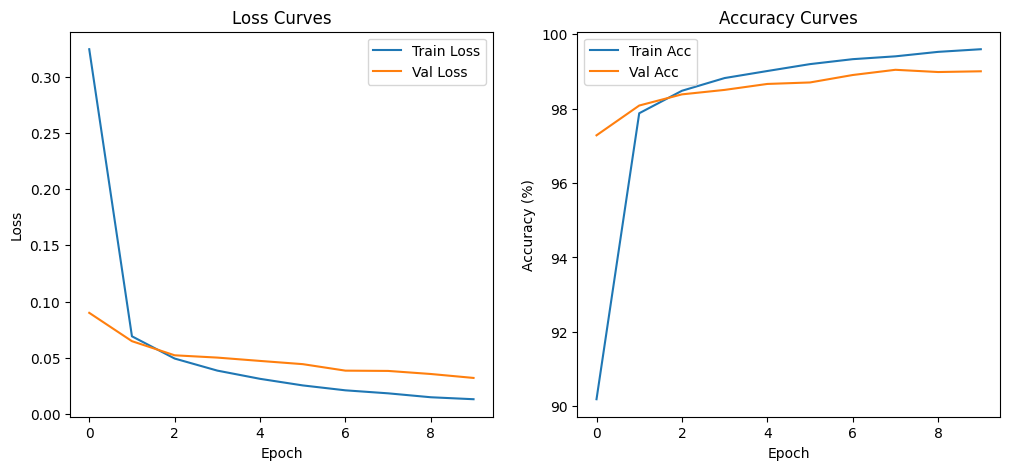

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# --- 1. DATA PREPARATION (Fixes the NameError) ---
transform_base = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download datasets
train_full = datasets.MNIST(root="./data", train=True, download=True, transform=transform_base)
test_set = datasets.MNIST(root="./data", train=False, download=True, transform=transform_base)

# Split (55k train, 5k val)
train_size = 55000
val_size = len(train_full) - train_size
train_set, val_set = random_split(train_full, [train_size, val_size],
                                  generator=torch.Generator().manual_seed(42))

# Define Loaders
BATCH_SIZE = 128
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# --- 2. MODEL ARCHITECTURE ---
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # 28x28 -> MaxPool(14x14) -> MaxPool(7x7)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# --- 3. TRAINING & EVALUATION FUNCTIONS ---
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct = 0.0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
    return running_loss / len(loader.dataset), 100. * correct / len(loader.dataset)

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct = 0.0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
    return running_loss / len(loader.dataset), 100. * correct / len(loader.dataset)

# --- 4. EXECUTION ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BaselineCNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

print(f"Starting training on {device}...")
for epoch in range(1, 11):
    t_loss, t_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    v_loss, v_acc = evaluate(model, val_loader, criterion, device)

    history['train_loss'].append(t_loss)
    history['val_loss'].append(v_loss)
    history['train_acc'].append(t_acc)
    history['val_acc'].append(v_acc)

    print(f"Epoch {epoch:02d} | Train Loss: {t_loss:.4f} Acc: {t_acc:.2f}% | Val Loss: {v_loss:.4f} Acc: {v_acc:.2f}%")

# Deliverable A: Learning Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.legend(); plt.title('Accuracy Curves')
plt.show()

##Part B — Diagnosing Underfitting vs Overfitting

In [ ]:
# 1. Calculate Generalization Gap using the last epoch results from Part A
final_train_loss = history['train_loss'][-1]
final_val_loss = history['val_loss'][-1]
delta_gen = final_val_loss - final_train_loss

print(f"Final Train Loss: {final_train_loss:.4f}")
print(f"Final Val Loss: {final_val_loss:.4f}")
print(f"Generalization Gap (Delta_gen): {delta_gen:.4f}")

# 2. Automated Diagnostic Logic
print("\n--- Diagnostic Report ---")
if final_train_loss > 0.1:
    print("Status: Possible Underfitting. The training loss is still quite high.")
elif delta_gen > 0.05:
    print("Status: Overfitting. There is a significant gap between training and validation loss.")
else:
    print("Status: Well-fit. The model generalizes well with a small gap.")

Final Train Loss: 0.0132
Final Val Loss: 0.0321
Generalization Gap (Delta_gen): 0.0189

--- Diagnostic Report ---
Status: Well-fit. The model generalizes well with a small gap.


##Part C — Data Augmentation Experiment

Starting Augmented Training...
Epoch 01 | Aug Train Acc: 83.94% | Val Acc: 96.86%
Epoch 02 | Aug Train Acc: 96.01% | Val Acc: 97.76%
Epoch 03 | Aug Train Acc: 97.13% | Val Acc: 98.72%
Epoch 04 | Aug Train Acc: 97.64% | Val Acc: 98.58%
Epoch 05 | Aug Train Acc: 97.88% | Val Acc: 98.80%
Epoch 06 | Aug Train Acc: 98.15% | Val Acc: 98.88%
Epoch 07 | Aug Train Acc: 98.23% | Val Acc: 99.08%
Epoch 08 | Aug Train Acc: 98.32% | Val Acc: 98.84%
Epoch 09 | Aug Train Acc: 98.50% | Val Acc: 99.10%
Epoch 10 | Aug Train Acc: 98.53% | Val Acc: 99.06%

--- Comparison Table: Baseline vs Augmented ---
                Metric  Baseline  Augmented
Final Val Accuracy (%) 99.000000  99.060000
        Final Val Loss  0.032133   0.026705
   Train-Val Gap (Acc)  0.592727  -0.530909


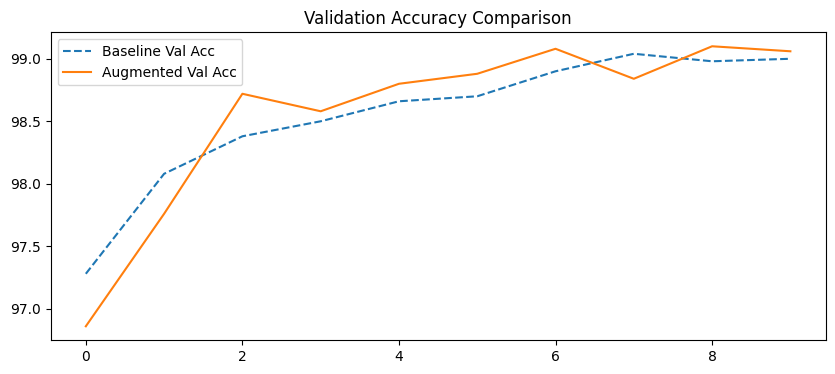

In [ ]:
import pandas as pd # For the comparison table

# 1. Define Training-only Augmentation Transform
transform_aug = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# 2. Create Augmented Dataset (Training only)
# We apply the transform to the full MNIST and then subset it using baseline indices
train_full_aug = datasets.MNIST(root="./data", train=True, download=True, transform=transform_aug)
train_set_aug = torch.utils.data.Subset(train_full_aug, train_set.indices)

train_loader_aug = DataLoader(train_set_aug, batch_size=128, shuffle=True, num_workers=2)

# 3. Train the same model architecture again
print("Starting Augmented Training...")
model_aug = BaselineCNN().to(device)
optimizer_aug = optim.SGD(model_aug.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

history_aug = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(1, 11):
    t_loss, t_acc = train_one_epoch(model_aug, train_loader_aug, optimizer_aug, criterion, device)
    v_loss, v_acc = evaluate(model_aug, val_loader, criterion, device) # Val loader uses base transform

    history_aug['train_loss'].append(t_loss)
    history_aug['val_loss'].append(v_loss)
    history_aug['train_acc'].append(t_acc)
    history_aug['val_acc'].append(v_acc)
    print(f"Epoch {epoch:02d} | Aug Train Acc: {t_acc:.2f}% | Val Acc: {v_acc:.2f}%")

# 4. Deliverable C: Small Comparison Table
comparison_data = {
    "Metric": ["Final Val Accuracy (%)", "Final Val Loss", "Train-Val Gap (Acc)"],
    "Baseline": [
        history['val_acc'][-1],
        history['val_loss'][-1],
        history['train_acc'][-1] - history['val_acc'][-1]
    ],
    "Augmented": [
        history_aug['val_acc'][-1],
        history_aug['val_loss'][-1],
        history_aug['train_acc'][-1] - history_aug['val_acc'][-1]
    ]
}

df_compare = pd.DataFrame(comparison_data)
print("\n--- Comparison Table: Baseline vs Augmented ---")
print(df_compare.to_string(index=False))

# Optional Visualization of Augmentation
plt.figure(figsize=(10, 4))
plt.plot(history['val_acc'], label='Baseline Val Acc', linestyle='--')
plt.plot(history_aug['val_acc'], label='Augmented Val Acc')
plt.title('Validation Accuracy Comparison')
plt.legend()
plt.show()


##Part D — Weight Decay (L2 Regularization) Sweep

Starting Weight Decay Sweep...
Testing Lambda = 0
Testing Lambda = 1e-05
Testing Lambda = 0.0001
Testing Lambda = 0.001

--- Weight Decay Results ---
 Lambda  Train Loss  Val Loss  Train Acc (%)  Val Acc (%)  Gap (L_val - L_train)
0.00000      0.0294    0.0411          99.08        98.72                 0.0117
0.00001      0.0310    0.0449          99.02        98.74                 0.0139
0.00010      0.0310    0.0421          99.05        98.80                 0.0111
0.00100      0.0343    0.0446          98.93        98.56                 0.0103


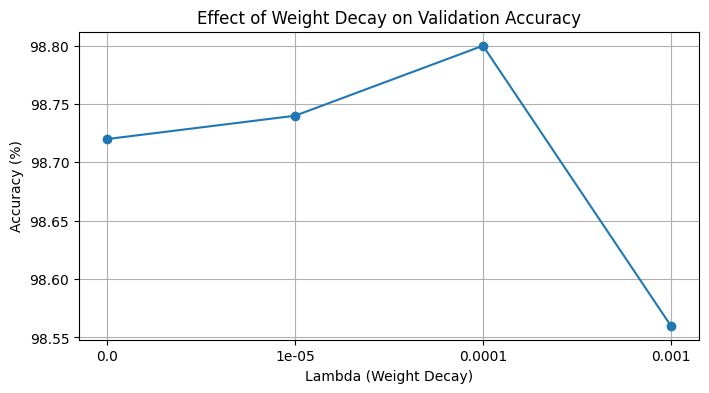

In [ ]:
import pandas as pd

# 1. Configuration for the sweep
lambdas = [0, 1e-5, 1e-4, 1e-3]
results_list = []

print("Starting Weight Decay Sweep...")

for ld in lambdas:
    print(f"Testing Lambda = {ld}")

    # Initialize fresh model and optimizer with specific weight decay
    model_wd = BaselineCNN().to(device)
    optimizer_wd = optim.SGD(model_wd.parameters(), lr=0.01, momentum=0.9, weight_decay=ld)
    criterion = nn.CrossEntropyLoss()

    # Train for 5 epochs (sufficient to see the trend)
    for epoch in range(1, 6):
        t_loss, t_acc = train_one_epoch(model_wd, train_loader, optimizer_wd, criterion, device)
        v_loss, v_acc = evaluate(model_wd, val_loader, criterion, device)

    # Store results from the final epoch of the sweep
    results_list.append({
        "Lambda": ld,
        "Train Loss": round(t_loss, 4),
        "Val Loss": round(v_loss, 4),
        "Train Acc (%)": round(t_acc, 2),
        "Val Acc (%)": round(v_acc, 2),
        "Gap (L_val - L_train)": round(v_loss - t_loss, 4)
    })

# 2. Deliverable D: Comparison Table
df_wd = pd.DataFrame(results_list)
print("\n--- Weight Decay Results ---")
print(df_wd.to_string(index=False))

# 3. Simple Plot for Visualization
plt.figure(figsize=(8, 4))
plt.plot(df_wd['Lambda'].astype(str), df_wd['Val Acc (%)'], marker='o', label='Val Accuracy')
plt.xlabel('Lambda (Weight Decay)')
plt.ylabel('Accuracy (%)')
plt.title('Effect of Weight Decay on Validation Accuracy')
plt.grid(True)
plt.show()

##Part E — Implicit Regularization (Dropout Sweep)

In [ ]:
# 1. Configuration for Dropout Sweep
dropout_rates = [0.0, 0.2, 0.5]
dropout_results = []

print("Starting Dropout Sweep...")

for p in dropout_rates:
    print(f"Testing Dropout Probability = {p}")

    # Initialize fresh model with the specific dropout rate
    model_drop = BaselineCNN(dropout_p=p).to(device)
    optimizer_drop = optim.SGD(model_drop.parameters(), lr=0.01, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    # Train for 10 epochs as per instructions
    for epoch in range(1, 11):
        t_loss, t_acc = train_one_epoch(model_drop, train_loader, optimizer_drop, criterion, device)
        v_loss, v_acc = evaluate(model_drop, val_loader, criterion, device)

    dropout_results.append({
        "Dropout Rate (p)": p,
        "Final Train Acc (%)": round(t_acc, 2),
        "Final Val Acc (%)": round(v_acc, 2),
        "Gap": round(t_acc - v_acc, 2)
    })

# 2. Deliverable E: Results and Bias-Variance Table
df_dropout = pd.DataFrame(dropout_results)
print("\n--- Dropout Results ---")
print(df_dropout.to_string(index=False))

##Part F — Early Stopping

In [ ]:
# Part F: Implementation of Early Stopping
def train_with_early_stopping(model, train_loader, val_loader, optimizer, criterion, device, patience=2):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_epoch = 0

    print("Training with Early Stopping...")
    for epoch in range(1, 11):
        t_loss, t_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        v_loss, v_acc = evaluate(model, val_loader, criterion, device)

        print(f"Epoch {epoch}: Val Loss = {v_loss:.4f}")

        if v_loss < best_val_loss:
            best_val_loss = v_loss
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_model_checkpoint.pth')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered at epoch {epoch}")
                return epoch, best_epoch, v_acc

    return 10, best_epoch, v_acc

# Execution
model_es = BaselineCNN(dropout_p=0.2).to(device)
opt_es = optim.SGD(model_es.parameters(), lr=0.01, momentum=0.9)
stop_ep, best_ep, best_acc = train_with_early_stopping(model_es, train_loader, val_loader, opt_es, criterion, device)

print(f"\nDeliverable F: Stopped at {stop_ep}, Best Val Loss at Epoch {best_ep}, Best Accuracy: {best_acc:.2f}%")

In [ ]:
# 1. Setup the configurations to test
configs = [
    {'name': 'SGD_LR_0.1',   'opt': optim.SGD,  'lr': 0.1,   'extra': {'momentum': 0.9}},
    {'name': 'SGD_LR_0.01',  'opt': optim.SGD,  'lr': 0.01,  'extra': {'momentum': 0.9}},
    {'name': 'Adam_LR_1e-3', 'opt': optim.Adam, 'lr': 1e-3,  'extra': {}},
    {'name': 'Adam_LR_3e-4', 'opt': optim.Adam, 'lr': 3e-4,  'extra': {}}
]

best_overall_acc = 0
best_config_name = ""
tuning_results = []

for cfg in configs:
    print(f"Testing {cfg['name']}...")
    # Use best regularization found (e.g., p=0.2)
    model = BaselineCNN(dropout_p=0.2).to(device)
    optimizer = cfg['opt'](model.parameters(), lr=cfg['lr'], **cfg['extra'])

    # Train for 5-10 epochs
    for epoch in range(1, 11):
        train_one_epoch(model, train_loader, optimizer, criterion, device)
        v_loss, v_acc = evaluate(model, val_loader, criterion, device)

    tuning_results.append({'Config': cfg['name'], 'Val_Acc': v_acc})

    if v_acc > best_overall_acc:
        best_overall_acc = v_acc
        best_config_name = cfg['name']
        # Save this specific model for Part H
        torch.save(model.state_dict(), 'best_tuned_model.pth')

# Deliverable G: Best configuration
df_tuning = pd.DataFrame(tuning_results)
print("\n--- Tuning Results ---")
print(df_tuning.to_string(index=False))
print(f"\nWINNER: {best_config_name} with {best_overall_acc:.2f}% accuracy")

##Part G — Hyperparameter Tuning (Optimizer + Learning Rate)

In [ ]:
# 1. Load the best configuration (Champion Model)
# Re-instantiate the model structure
final_model = BaselineCNN(dropout_p=0.2).to(device)
final_model.load_state_dict(torch.load('best_tuned_model.pth'))

# 2. Final Evaluation on Test Set
test_loss, test_acc = evaluate(final_model, test_loader, criterion, device)

print("--- Deliverable H: Final Results ---")
print(f"Final Chosen Configuration: {best_config_name}")
print(f"Final Test Accuracy: {test_acc:.2f}%")
print(f"Final Test Loss: {test_loss:.4f}")

# Optional: Simple Confusion Matrix logic
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, loader, device):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Final Test Confusion Matrix')
    plt.show()

plot_confusion_matrix(final_model, test_loader, device)